# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [13]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


Instalación de dependencias

In [2]:
pip install pandas requests lxml


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


 Descargar HTML

In [44]:
url = "http://quotes.toscrape.com/"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0 Safari/537.3"}
response = requests.get(url, headers=headers)

response



<Response [200]>

Transformar el HTML

In [45]:
soup = BeautifulSoup(response.text, 'html.parser')
soup

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<title>Quotes to Scrape</title>
<link href="/static/bootstrap.min.css" rel="stylesheet"/>
<link href="/static/main.css" rel="stylesheet"/>
</head>
<body>
<div class="container">
<div class="row header-box">
<div class="col-md-8">
<h1>
<a href="/" style="text-decoration: none">Quotes to Scrape</a>
</h1>
</div>
<div class="col-md-4">
<p>
<a href="/login">Login</a>
</p>
</div>
</div>
<div class="row">
<div class="col-md-8">
<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="

In [46]:
quotes = soup.find_all("div", class_="quote")

data = []
for q in quotes:
    texto = q.find("span", class_="text").text.strip()
    autor = q.find("small", class_="author").text.strip()
    tags = [tag.text for tag in q.find_all("a", class_="tag")]
    data.append((texto, autor, ", ".join(tags)))

df_quotes = pd.DataFrame(data, columns=["Cita", "Autor", "Etiquetas"])
df_quotes.head()

,Cita,Autor,Etiquetas
0,“The world as we have created it is a process ...,Albert Einstein,"change, deep-thoughts, thinking, world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"abilities, choices"
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational, life, live, miracle, miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy, books, classic, humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself, inspirational"


In [53]:
df_quotes.info()
df_quotes.head()
df_quotes.drop_duplicates(inplace=True)
df_quotes["Cita"] = df_quotes["Cita"].str.replace("“", "").str.replace("”", "").str.strip()
df_quotes["Autor"] = df_quotes["Autor"].str.strip()
df_quotes["Etiquetas"] = df_quotes["Etiquetas"].str.strip()
df_quotes["NumEtiquetas"] = df_quotes["Etiquetas"].apply(lambda x: len(x.split(", ")) if isinstance(x, str) and x.strip() != "" else 0) 
df_quotes["NumPalabras"] = df_quotes["Cita"].apply(lambda x: len(x.split()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Cita          100 non-null    object
 1   Autor         100 non-null    object
 2   Etiquetas     100 non-null    object
 3   NumEtiquetas  100 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 3.3+ KB


In [55]:
top_autores = df_quotes["Autor"].value_counts().head()
top_autores

Autor
Albert Einstein    10
J.K. Rowling        9
Marilyn Monroe      7
Dr. Seuss           6
Mark Twain          6
Name: count, dtype: int64

In [ ]:
conn = sqlite3.connect("quotes.db")
df_quotes.to_sql("citas", conn, if_exists="replace", index=False)
conn.commit()
conn.close()

## VISUALIZACIÓN

 AUTORES CON MAS LECTURAS

/tmp/ipykernel_720/2955248225.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette="viridis")


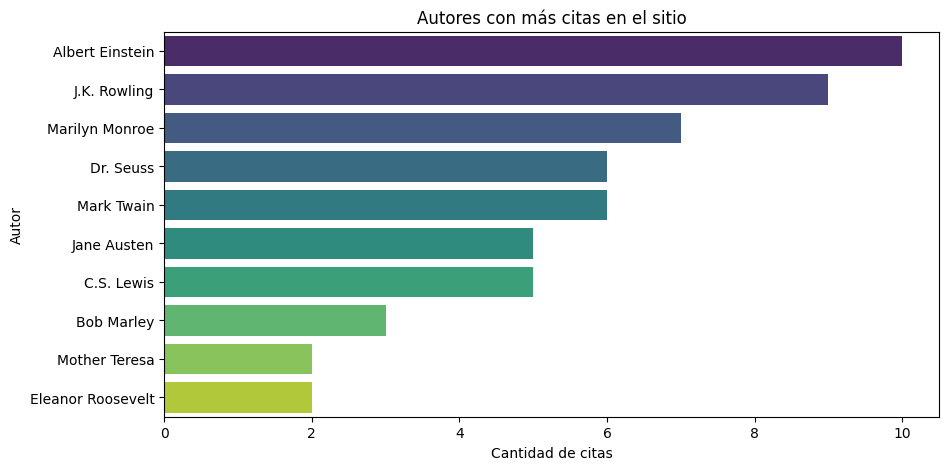

In [64]:
top_authors = df_quotes["Autor"].value_counts().nlargest(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="viridis")
plt.title("Autores con más citas en el sitio")
plt.xlabel("Cantidad de citas")
plt.ylabel("Autor")
plt.show()

AUTORES CON LECTURAS MAS LARGAS

/tmp/ipykernel_720/186228064.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=promedio_palabras.values, y=promedio_palabras.index, palette="magma")


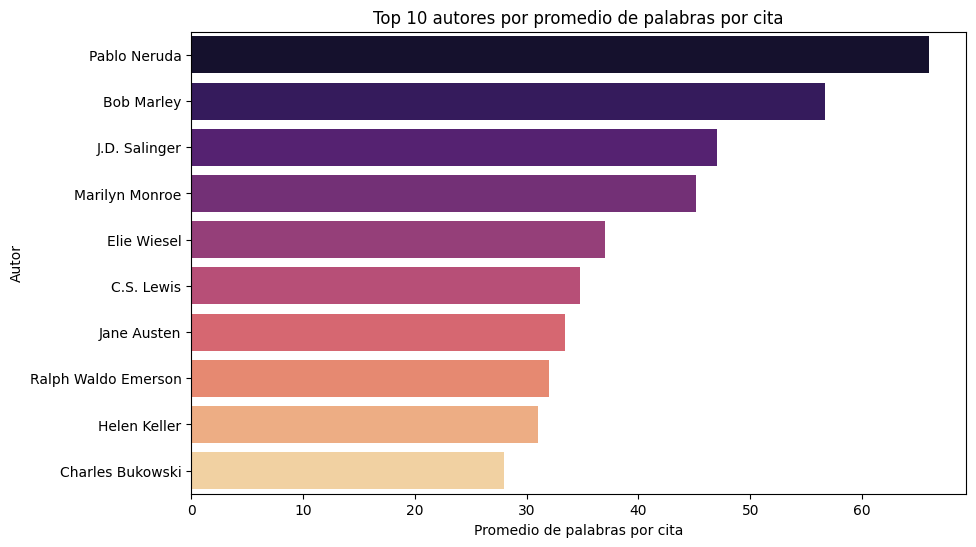

In [60]:
promedio_palabras = df_quotes.groupby("Autor")["NumPalabras"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=promedio_palabras.values, y=promedio_palabras.index, palette="magma")
plt.title("Top 10 autores por promedio de palabras por cita")
plt.xlabel("Promedio de palabras por cita")
plt.ylabel("Autor")
plt.show()

POR LONGITUD DE CITAS

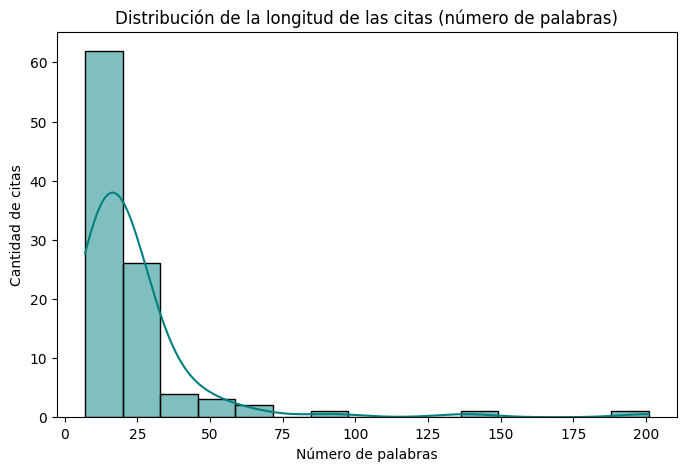

In [71]:
plt.figure(figsize=(8,5))
sns.histplot(df_quotes["NumPalabras"], bins=15, kde=True, color="teal")
plt.title("Distribución de la longitud de las citas (número de palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Cantidad de citas")
plt.show()